Preview of the dataset:
   0   1        2       3      4       5       6        7        8     9   \
0   1   1  42.0049  0.8400  100.0  445.00  549.68  1343.43  1112.93  3.91   
1   1   2  20.0020  0.7002  100.0  491.19  606.07  1477.61  1237.50  9.35   
2   1   3  42.0038  0.8409  100.0  445.00  548.95  1343.12  1117.05  3.91   
3   1   4  42.0000  0.8400  100.0  445.00  548.70  1341.24  1118.03  3.91   
4   1   5  25.0063  0.6207   60.0  462.54  536.10  1255.23  1033.59  7.05   

   ...      16       17       18       19    20   21    22      23     24  \
0  ...  129.78  2387.99  8074.83   9.3335  0.02  330  2212  100.00  10.62   
1  ...  312.59  2387.73  8046.13   9.1913  0.02  361  2324  100.00  24.37   
2  ...  129.62  2387.97  8066.62   9.4007  0.02  329  2212  100.00  10.48   
3  ...  129.80  2388.02  8076.05   9.3369  0.02  328  2212  100.00  10.54   
4  ...  164.11  2028.08  7865.80  10.8366  0.02  305  1915   84.93  14.03   

        25  
0   6.3670  
1  14.6552  
2   6.4213 

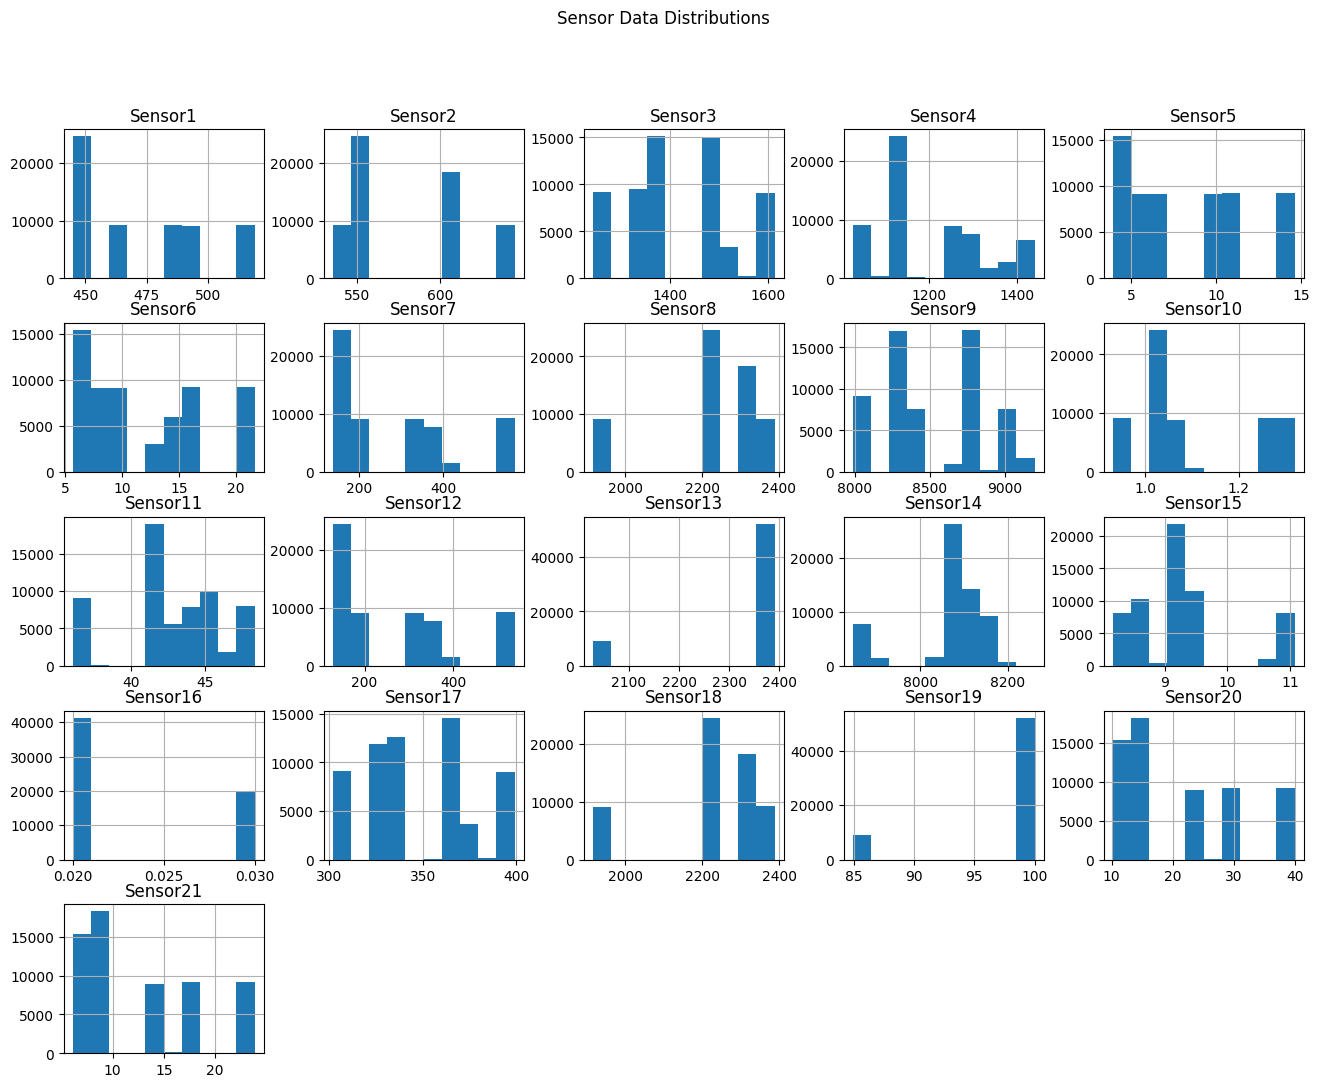

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load new dataset (replace with your new file path)
new_dataset_path = '/content/train_FD004.txt'

# Load the dataset and inspect the first few rows
new_data = pd.read_csv(new_dataset_path, sep=" ", header=None)
new_data.dropna(axis=1, inplace=True)  # Clean up any extra columns
print("Preview of the dataset:")
print(new_data.head())

# Determine column names dynamically
# Assuming the first few columns are Engine ID, Cycle, and Operational Settings
num_columns = new_data.shape[1]
if num_columns == 26:  # Same structure as previous
    new_data.columns = ['Engine ID', 'Cycle', 'OpSetting1', 'OpSetting2', 'OpSetting3'] + [f'Sensor{i}' for i in range(1, 22)]
elif num_columns > 26:  # Extra columns present
    new_data.columns = ['Engine ID', 'Cycle', 'OpSetting1', 'OpSetting2', 'OpSetting3'] + [f'Sensor{i}' for i in range(1, 22)] + [f'ExtraCol{i}' for i in range(1, num_columns - 26 + 1)]
else:  # Fewer columns
    print(f"Dataset has fewer columns ({num_columns}). Adjusting column names...")
    num_sensors = num_columns - 3  # Deduct Engine ID, Cycle, and 1 Operational Setting
    new_data.columns = ['Engine ID', 'Cycle', 'OpSetting1'] + [f'Sensor{i}' for i in range(1, num_sensors + 1)]

# Descriptive statistics
print("Descriptive Statistics:")
print(new_data.describe())

# Plot histograms for sensors
sensor_columns = [col for col in new_data.columns if 'Sensor' in col]
if sensor_columns:
    new_data[sensor_columns].hist(figsize=(16, 12))
    plt.suptitle('Sensor Data Distributions')
    plt.show()
else:
    print("No sensor data columns detected for histogram plotting.")


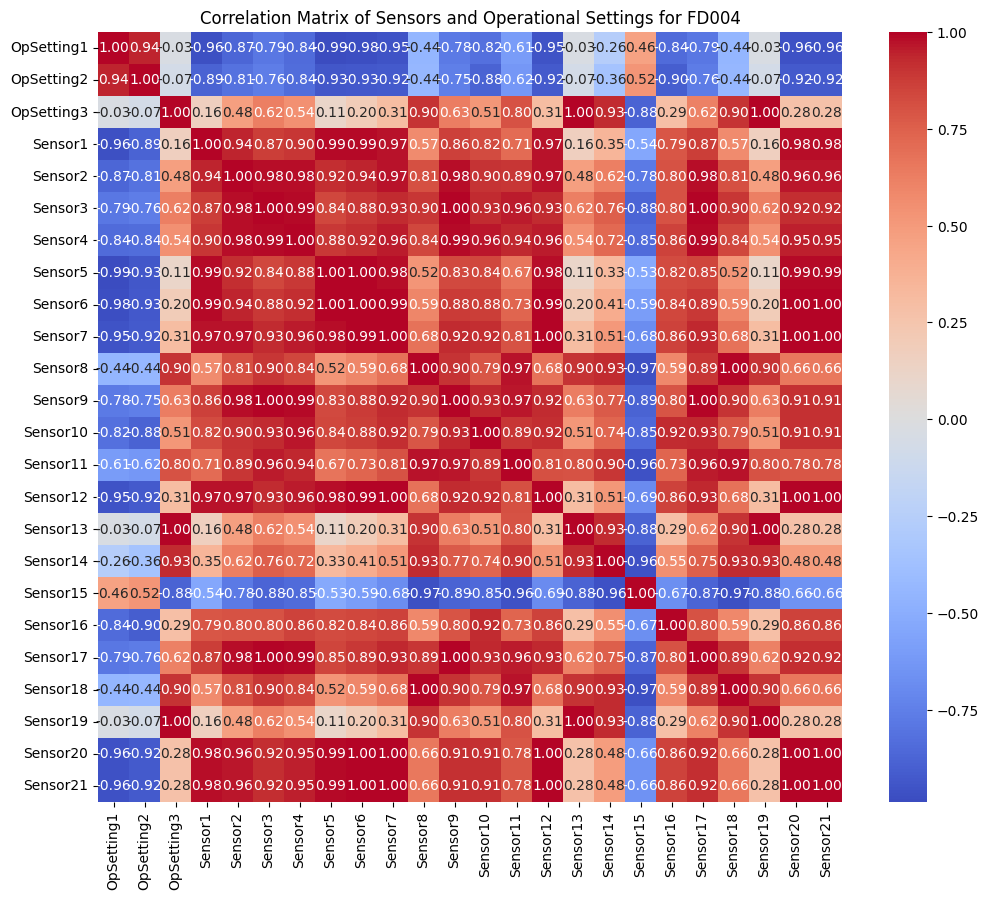

Correlation of features with RUL:
RUL           1.000000
Sensor20      0.002812
Sensor21      0.002791
Sensor18      0.002765
Sensor19      0.002303
OpSetting3    0.002303
Sensor8       0.002086
Sensor1       0.001889
Sensor5       0.001679
Sensor13      0.001501
Sensor6       0.001349
Sensor7      -0.001429
Sensor12     -0.001639
OpSetting2   -0.002280
OpSetting1   -0.002380
Sensor15     -0.003957
Sensor2      -0.004443
Sensor10     -0.008924
Sensor9      -0.024727
Sensor3      -0.032924
Sensor17     -0.032939
Sensor4      -0.045881
Sensor16     -0.053804
Sensor11     -0.056639
Sensor14     -0.078126
Name: RUL, dtype: float64


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Load FD002 dataset
train_fd002 = pd.read_csv('/content/train_FD004.txt', sep=" ", header=None)
train_fd002.dropna(axis=1, inplace=True)  # Remove extra columns
train_fd002.columns = ['Engine ID', 'Cycle', 'OpSetting1', 'OpSetting2', 'OpSetting3'] + [f'Sensor{i}' for i in range(1, 22)]

# Standardize data (exclude Engine ID and Cycle)
numeric_columns = train_fd002.columns[2:]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(train_fd002[numeric_columns])
scaled_df = pd.DataFrame(scaled_data, columns=numeric_columns)

# Calculate and plot the correlation matrix
correlation_matrix = scaled_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Sensors and Operational Settings for FD004')
plt.show()

# Add RUL column
train_fd002['Max Cycle'] = train_fd002.groupby('Engine ID')['Cycle'].transform('max')
train_fd002['RUL'] = train_fd002['Max Cycle'] - train_fd002['Cycle']
train_fd002.drop(columns=['Max Cycle'], inplace=True)

# Correlation with RUL
correlations_with_rul = scaled_df.join(train_fd002['RUL']).corr()['RUL'].sort_values(ascending=False)
print("Correlation of features with RUL:")
print(correlations_with_rul)

Loading FD004 dataset...
Calculating RUL...
Performing feature engineering...
Preparing data...
Scaling features...
Training Random Forest model...
Making predictions...
Random Forest Test RMSE: 42.688764858698946
Random Forest Test R^2: 0.3870076502583526


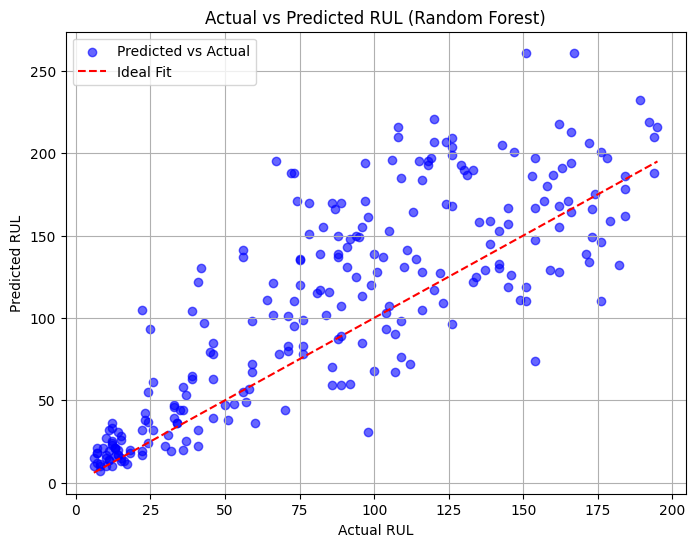


Predicted Class Distribution (Whole Numbers):
Predicted Classification
Healthy     72
Warning     28
Critical     0

Actual Class Distribution (Whole Numbers):
Actual Classification
Healthy     68
Warning     28
Critical     4
Results saved to 'rf_fd004_predictions_with_classifications.csv'.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import joblib

# Load FD004 dataset
print("Loading FD004 dataset...")
train_data = pd.read_csv('/content/train_FD004.txt', sep="\s+", header=None)
test_data = pd.read_csv('/content/test_FD004.txt', sep="\s+", header=None)
rul_test = pd.read_csv('/content/RUL_FD004.txt', header=None)

# Assign column names
columns = ['Engine ID', 'Cycle'] + [f'OpSetting{i}' for i in range(1, 4)] + [f'Sensor{i}' for i in range(1, 22)]
train_data.columns = columns
test_data.columns = columns
rul_test.columns = ['RUL']

# Calculate RUL for training data
print("Calculating RUL...")
train_data['Max Cycle'] = train_data.groupby('Engine ID')['Cycle'].transform('max')
train_data['RUL'] = train_data['Max Cycle'] - train_data['Cycle']
train_data.drop(columns=['Max Cycle'], inplace=True)

# Feature Engineering: Adding rolling statistics
print("Performing feature engineering...")
for dataset in [train_data, test_data]:
    for sensor in ['Sensor3', 'Sensor4', 'Sensor9', 'Sensor11', 'Sensor15']:
        dataset[f'{sensor}_rolling_mean'] = dataset.groupby('Engine ID')[sensor].rolling(window=5).mean().reset_index(level=0, drop=True)
        dataset[f'{sensor}_rolling_std'] = dataset.groupby('Engine ID')[sensor].rolling(window=5).std().reset_index(level=0, drop=True)
        dataset[f'{sensor}_diff'] = dataset.groupby('Engine ID')[sensor].diff()

# Drop unnecessary columns based on correlation analysis
drop_columns = ['Sensor1', 'Sensor5', 'Sensor10', 'Sensor16', 'Sensor18', 'Sensor19', 'OpSetting3']
train_data.drop(columns=drop_columns, inplace=True)
test_data.drop(columns=drop_columns, inplace=True)

# Prepare training and test data
print("Preparing data...")
X_train = train_data.drop(columns=['RUL', 'Engine ID', 'Cycle'])
y_train = train_data['RUL']
X_test = test_data.groupby('Engine ID').last().reset_index().drop(columns=['Engine ID', 'Cycle'])
y_test = rul_test['RUL']

# Ensure feature consistency between train and test sets
features = X_train.columns
X_test = X_test[features]

# Scale features
print("Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save scaler and features
joblib.dump(scaler, 'scaler_fd004.pkl')
joblib.dump(features.tolist(), 'features_fd004.pkl')

# Train Random Forest model
print("Training Random Forest model...")
rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Save model
joblib.dump(rf_model, 'rf_model_fd004.pkl')

# Make predictions
print("Making predictions...")
y_pred = rf_model.predict(X_test_scaled)
y_pred = np.round(y_pred).astype(int)  # Convert predictions to whole numbers

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Random Forest Test RMSE: {rmse}")
print(f"Random Forest Test R^2: {r2}")

# Visualize Predictions
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs Predicted RUL (Random Forest)')
plt.legend()
plt.grid()
plt.show()

# Define RUL Categories
def classify_rul(rul):
    if rul < 10:
        return "Critical"
    elif 10 <= rul <= 50:
        return "Warning"
    else:
        return "Healthy"

# Add Predictions and Classifications
results_df = pd.DataFrame({
    'Engine ID': test_data['Engine ID'].unique(),
    'Predicted RUL': y_pred,
    'Actual RUL': y_test
})

results_df['Predicted Classification'] = results_df['Predicted RUL'].apply(classify_rul)
results_df['Actual Classification'] = results_df['Actual RUL'].apply(classify_rul)

# Display Class Distributions
predicted_class_distribution = results_df['Predicted Classification'].value_counts(normalize=True) * 100
actual_class_distribution = results_df['Actual Classification'].value_counts(normalize=True) * 100

# Convert percentages to whole numbers
predicted_class_distribution = predicted_class_distribution.round(0).astype(int)
actual_class_distribution = actual_class_distribution.round(0).astype(int)

print("\nPredicted Class Distribution (Whole Numbers):")
print(predicted_class_distribution.to_string())
print("\nActual Class Distribution (Whole Numbers):")
print(actual_class_distribution.to_string())

# Save results to CSV
results_df.to_csv('rf_fd004_predictions_with_classifications.csv', index=False)
print("Results saved to 'rf_fd004_predictions_with_classifications.csv'.")


Loading FD004 dataset...
Calculating RUL...
Performing feature engineering...
Preparing data...
Scaling features...
Training XGBoost model...
Making predictions...
XGBoost Test RMSE: 42.15558284074818
XGBoost Test R^2: 0.4022245407104492


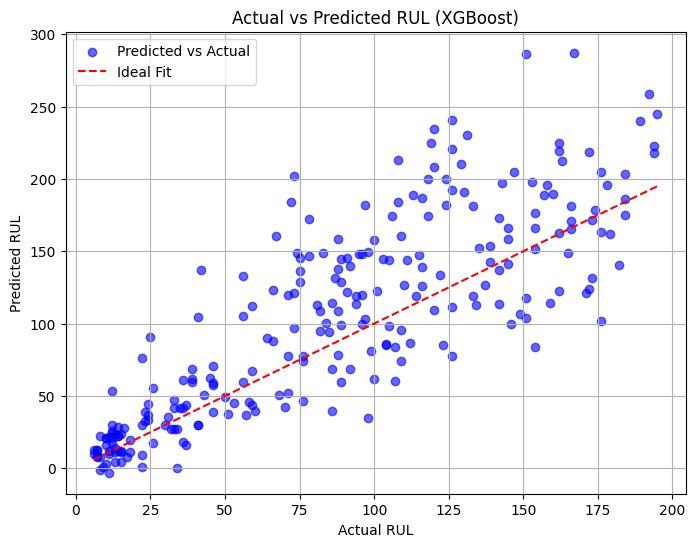


Predicted Class Distribution:
Predicted Classification
Healthy     69
Warning     25
Critical     5

Actual Class Distribution:
Actual Classification
Healthy     68
Warning     28
Critical     4
Results saved to 'xgb_fd004_predictions_with_classifications.csv'.


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import joblib

# Load FD004 dataset
print("Loading FD004 dataset...")
train_data = pd.read_csv('/content/train_FD004.txt', sep="\s+", header=None)
test_data = pd.read_csv('/content/test_FD004.txt', sep="\s+", header=None)
rul_test = pd.read_csv('/content/RUL_FD004.txt', header=None)

# Assign column names
columns = ['Engine ID', 'Cycle'] + [f'OpSetting{i}' for i in range(1, 4)] + [f'Sensor{i}' for i in range(1, 22)]
train_data.columns = columns
test_data.columns = columns
rul_test.columns = ['RUL']

# Add RUL column to train data
print("Calculating RUL...")
train_data['Max Cycle'] = train_data.groupby('Engine ID')['Cycle'].transform('max')
train_data['RUL'] = train_data['Max Cycle'] - train_data['Cycle']
train_data.drop(columns=['Max Cycle'], inplace=True)

# Feature Engineering: Adding rolling statistics
print("Performing feature engineering...")
for dataset in [train_data, test_data]:
    for sensor in ['Sensor3', 'Sensor4', 'Sensor9', 'Sensor11', 'Sensor15']:
        dataset[f'{sensor}_rolling_mean'] = dataset.groupby('Engine ID')[sensor].rolling(window=5).mean().reset_index(level=0, drop=True)
        dataset[f'{sensor}_rolling_std'] = dataset.groupby('Engine ID')[sensor].rolling(window=5).std().reset_index(level=0, drop=True)
        dataset[f'{sensor}_diff'] = dataset.groupby('Engine ID')[sensor].diff()

# Drop unnecessary columns based on correlation analysis
drop_columns = ['Sensor1', 'Sensor5', 'Sensor10', 'Sensor16', 'Sensor18', 'Sensor19', 'OpSetting3']
train_data.drop(columns=drop_columns, inplace=True)
test_data.drop(columns=drop_columns, inplace=True)

# Prepare training and testing data
print("Preparing data...")
X_train = train_data.drop(columns=['RUL', 'Engine ID', 'Cycle'])
y_train = train_data['RUL']
X_test = test_data.groupby('Engine ID').last().reset_index().drop(columns=['Engine ID', 'Cycle'])
y_test = rul_test['RUL']

# Ensure feature consistency between train and test sets
features = X_train.columns
X_test = X_test[features]

# Scale features
print("Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save scaler and features for reproducibility
joblib.dump(scaler, 'scaler_fd004.pkl')
joblib.dump(features.tolist(), 'features_fd004.pkl')

# Train XGBoost model
print("Training XGBoost model...")
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_estimators=200,
    max_depth=7,
    learning_rate=0.1,
    subsample=0.8
)
xgb_model.fit(X_train_scaled, y_train)

# Save the trained model
joblib.dump(xgb_model, 'xgb_model_fd004.pkl')

# Make predictions
print("Making predictions...")
y_pred = xgb_model.predict(X_test_scaled)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"XGBoost Test RMSE: {rmse}")
print(f"XGBoost Test R^2: {r2}")

# Visualize Predictions
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs Predicted RUL (XGBoost)')
plt.legend()
plt.grid()
plt.show()

# Define RUL Categories
def classify_rul(rul):
    if rul < 10:
        return "Critical"
    elif 10 <= rul <= 50:
        return "Warning"
    else:
        return "Healthy"

# Add Predictions and Classifications
results_df = pd.DataFrame({
    'Engine ID': test_data['Engine ID'].unique(),
    'Predicted RUL': np.round(y_pred),
    'Actual RUL': y_test
})

results_df['Predicted Classification'] = results_df['Predicted RUL'].apply(classify_rul)
results_df['Actual Classification'] = results_df['Actual RUL'].apply(classify_rul)

# Display Class Distributions
predicted_class_distribution = results_df['Predicted Classification'].value_counts(normalize=True) * 100
actual_class_distribution = results_df['Actual Classification'].value_counts(normalize=True) * 100

print("\nPredicted Class Distribution:")
print(predicted_class_distribution.round(0).astype(int).to_string())
print("\nActual Class Distribution:")
print(actual_class_distribution.round(0).astype(int).to_string())

# Save predictions with classifications to CSV
results_df.to_csv('xgb_fd004_predictions_with_classifications.csv', index=False)
print("Results saved to 'xgb_fd004_predictions_with_classifications.csv'.")


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Loading FD004 dataset...
Calculating RUL...
Performing feature engineering...
Preparing data...
Scaling features...
Training base models...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7591
[LightGBM] [Info] Number of data points in the train set: 61249, number of used features: 32
[LightGBM] [Info] Start training from score 133.311417
Optimizing blending weights...
Optimized Weights: [0.33383257 0.25623972 0.40992772]
Blended Ensemble Test RMSE: 41.014023492719204
Blended Ensemble Test R^2: 0.434161325612621


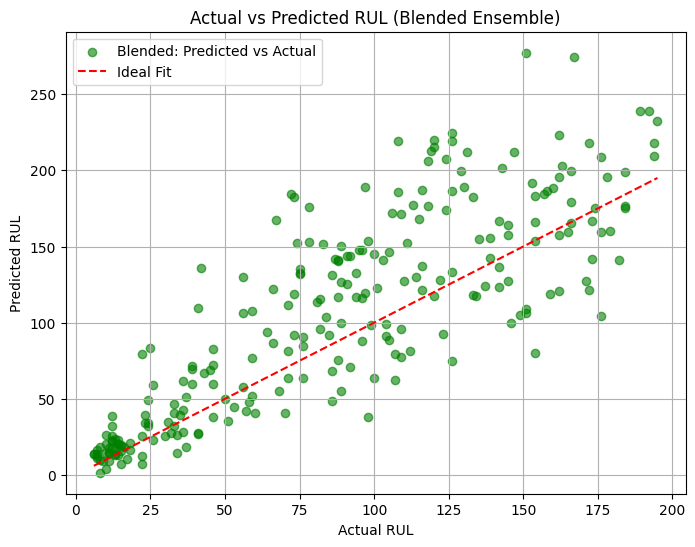


Percentage Distribution of Predicted Classifications:
Predicted Classification
Healthy     71
Warning     27
Critical     2

Percentage Distribution of Actual Classifications:
Actual Classification
Healthy     68
Warning     28
Critical     4
Results with classifications saved to 'blended_ensemble_predicted_vs_actual_rul_fd004_with_classifications.csv'.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import joblib

# Load FD004 dataset
print("Loading FD004 dataset...")
train_data = pd.read_csv('/content/train_FD004.txt', sep="\s+", header=None)
test_data = pd.read_csv('/content/test_FD004.txt', sep="\s+", header=None)
rul_test = pd.read_csv('/content/RUL_FD004.txt', header=None)

# Assign column names
columns = ['Engine ID', 'Cycle'] + [f'OpSetting{i}' for i in range(1, 4)] + [f'Sensor{i}' for i in range(1, 22)]
train_data.columns = columns
test_data.columns = columns
rul_test.columns = ['RUL']

# Add RUL column to train data
print("Calculating RUL...")
train_data['Max Cycle'] = train_data.groupby('Engine ID')['Cycle'].transform('max')
train_data['RUL'] = train_data['Max Cycle'] - train_data['Cycle']
train_data.drop(columns=['Max Cycle'], inplace=True)

# Feature Engineering: Adding rolling statistics
print("Performing feature engineering...")
for dataset in [train_data, test_data]:
    for sensor in ['Sensor3', 'Sensor4', 'Sensor9', 'Sensor11', 'Sensor15']:
        dataset[f'{sensor}_rolling_mean'] = dataset.groupby('Engine ID')[sensor].rolling(window=5).mean().reset_index(level=0, drop=True)
        dataset[f'{sensor}_rolling_std'] = dataset.groupby('Engine ID')[sensor].rolling(window=5).std().reset_index(level=0, drop=True)
        dataset[f'{sensor}_diff'] = dataset.groupby('Engine ID')[sensor].diff()

# Drop unnecessary columns based on correlation analysis
drop_columns = ['Sensor1', 'Sensor5', 'Sensor10', 'Sensor16', 'Sensor18', 'Sensor19', 'OpSetting3']
train_data.drop(columns=drop_columns, inplace=True)
test_data.drop(columns=drop_columns, inplace=True)

# Prepare training and testing data
print("Preparing data...")
X_train = train_data.drop(columns=['RUL', 'Engine ID', 'Cycle'])
y_train = train_data['RUL']
X_test = test_data.groupby('Engine ID').last().reset_index().drop(columns=['Engine ID', 'Cycle'])
y_test = rul_test['RUL']

# Ensure feature consistency between train and test sets
features = X_train.columns
X_test = X_test[features]

# Scale features
print("Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save scaler and features for reproducibility
joblib.dump(scaler, 'scaler_fd004.pkl')
joblib.dump(features.tolist(), 'features_fd004.pkl')

# Train Base Models
print("Training base models...")

# XGBoost
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_estimators=200,
    max_depth=7,
    learning_rate=0.1,
    subsample=0.8
)
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)

# LightGBM
lgb_model = lgb.LGBMRegressor(objective='regression', random_state=42, n_estimators=200, max_depth=7, learning_rate=0.1, subsample=0.8)
lgb_model.fit(X_train_scaled, y_train)
lgb_pred = lgb_model.predict(X_test_scaled)

# Blending: Optimize Weights
print("Optimizing blending weights...")

def objective(weights):
    blended_pred = weights[0] * xgb_pred + weights[1] * rf_pred + weights[2] * lgb_pred
    return np.sqrt(mean_squared_error(y_test, blended_pred))

constraints = [{'type': 'eq', 'fun': lambda weights: 1 - sum(weights)}]
bounds = [(0, 1)] * 3
initial_weights = [1/3, 1/3, 1/3]

result = minimize(objective, initial_weights, bounds=bounds, constraints=constraints)
optimized_weights = result.x
print(f"Optimized Weights: {optimized_weights}")

# Final Blended Prediction
blended_pred = optimized_weights[0] * xgb_pred + optimized_weights[1] * rf_pred + optimized_weights[2] * lgb_pred

# Evaluate the final blended model
blended_rmse = np.sqrt(mean_squared_error(y_test, blended_pred))
blended_r2 = r2_score(y_test, blended_pred)

print(f"Blended Ensemble Test RMSE: {blended_rmse}")
print(f"Blended Ensemble Test R^2: {blended_r2}")

# Visualize Results
plt.figure(figsize=(8, 6))
plt.scatter(y_test, blended_pred, color='green', label='Blended: Predicted vs Actual', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs Predicted RUL (Blended Ensemble)')
plt.legend()
plt.grid()
plt.show()

# Save predictions to DataFrame
results_df = pd.DataFrame({
    'Engine ID': test_data['Engine ID'].unique(),
    'Blended Predicted RUL': np.round(blended_pred),
    'Actual RUL': y_test
})

# Define RUL Categories
def classify_rul(rul):
    if rul < 10:
        return "Critical"
    elif 10 <= rul <= 50:
        return "Warning"
    else:
        return "Healthy"

# Add Classifications
results_df['Predicted Classification'] = results_df['Blended Predicted RUL'].apply(classify_rul)
results_df['Actual Classification'] = results_df['Actual RUL'].apply(classify_rul)

# Display Percentage Distribution of Classes
predicted_class_distribution = results_df['Predicted Classification'].value_counts(normalize=True) * 100
actual_class_distribution = results_df['Actual Classification'].value_counts(normalize=True) * 100

print("\nPercentage Distribution of Predicted Classifications:")
print(predicted_class_distribution.round(0).astype(int).to_string())
print("\nPercentage Distribution of Actual Classifications:")
print(actual_class_distribution.round(0).astype(int).to_string())

# Save Results with Classifications
results_df.to_csv('blended_ensemble_predicted_vs_actual_rul_fd004_with_classifications.csv', index=False)
print("Results with classifications saved to 'blended_ensemble_predicted_vs_actual_rul_fd004_with_classifications.csv'.")
